# **3. Correlation and PPS Notebook**

## Objectives

* Carry out regression and PPS analysis to prepare data for modelling

## Inputs

* Based on the cleaned dataset (HousePrices.csv)

## Outputs

* Regression and PPS outputs


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os

# Get the current directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Change the directory to the new path
os.chdir('/workspace/milestone-project-housing-issues')

# Get the updated current directory
current_dir = os.getcwd()
print("New Current Directory:", current_dir)

Current Directory: /workspace/milestone-project-housing-issues/jupyter_notebooks
New Current Directory: /workspace/milestone-project-housing-issues


In [2]:
# Import packages for correlation analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Load and Inspect Dataset

Load dataset and confirm no missing data

In [3]:
# Load dataset
import pandas as pd
df_houseprices = pd.read_csv(f"/workspace/milestone-project-housing-issues/outputs/datasets/collection/HousePricesClean.csv")
df_houseprices.head()

,1stFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinType1,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,...,OverallQual,TotalBsmtSF,YearBuilt,SalePrice,Has2ndFloor,HasMasVnr,HasOpenPorch,HasGarage,HasFinBsmt,ModsMade
0,856,3,No,GLQ,RFn,2003,1710,Gd,8450,65,...,7,856,2003,208500,1,1,1,1,1,0
1,1262,3,Gd,ALQ,RFn,1976,1262,TA,9600,80,...,6,1262,1976,181500,0,0,0,1,1,0
2,920,3,Mn,GLQ,RFn,2001,1786,Gd,11250,68,...,7,920,2001,223500,1,1,1,1,1,1
3,961,2,No,ALQ,Unf,1998,1717,Gd,9550,60,...,7,756,1915,140000,0,0,1,1,1,1
4,1145,4,Av,GLQ,RFn,2000,2198,Gd,14260,84,...,8,1145,2000,250000,0,1,1,1,1,0


In [4]:
#Using EvaluateMissingData() function to display missing data for df_houseprices_clean
def EvaluateMissingData(df_houseprices):
  missing_data_absolute = df_houseprices.isnull().sum()
  missing_data_percentage = round(missing_data_absolute/len(df_houseprices)*100, 2)
  df_missing_data = (pd.DataFrame(
              data={"RowsWithMissingData": missing_data_absolute,
                  "PercentageOfDataset": missing_data_percentage,
                  "DataType": df_houseprices.dtypes}
                  )
             .sort_values(by=['PercentageOfDataset'], ascending=False)
             .query("PercentageOfDataset > 0")
             )

  return df_missing_data

EvaluateMissingData(df_houseprices)

,RowsWithMissingData,PercentageOfDataset,DataType


In [5]:
df_houseprices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   1stFlrSF      1460 non-null   int64 
 1   BedroomAbvGr  1460 non-null   int64 
 2   BsmtExposure  1460 non-null   object
 3   BsmtFinType1  1460 non-null   object
 4   GarageFinish  1460 non-null   object
 5   GarageYrBlt   1460 non-null   int64 
 6   GrLivArea     1460 non-null   int64 
 7   KitchenQual   1460 non-null   object
 8   LotArea       1460 non-null   int64 
 9   LotFrontage   1460 non-null   int64 
 10  OverallCond   1460 non-null   int64 
 11  OverallQual   1460 non-null   int64 
 12  TotalBsmtSF   1460 non-null   int64 
 13  YearBuilt     1460 non-null   int64 
 14  SalePrice     1460 non-null   int64 
 15  Has2ndFloor   1460 non-null   int64 
 16  HasMasVnr     1460 non-null   int64 
 17  HasOpenPorch  1460 non-null   int64 
 18  HasGarage     1460 non-null   int64 
 19  HasFin

#### Recoding categorical to numerical data for regression analysis

In [6]:
for col in df_houseprices.select_dtypes(include='object').columns:
    print(f"{col}: {df_houseprices[col].unique()}")

BsmtExposure: ['No' 'Gd' 'Mn' 'Av' 'None']
BsmtFinType1: ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'None' 'LwQ']
GarageFinish: ['RFn' 'Unf' 'Fin' 'None']
KitchenQual: ['Gd' 'TA' 'Ex' 'Fa']


In [7]:
# Recode to change object variables to integers

mappings = {
    'BsmtExposure': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
    'BsmtFinType1': {'None': 0, 'Missing': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'GarageFinish': {'None': 0, 'Missing': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
    'KitchenQual': {'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
}

for col, mapping in mappings.items():
    df_houseprices[col] = df_houseprices[col].map(mapping).astype(int)

df_houseprices.head()

,1stFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinType1,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,...,OverallQual,TotalBsmtSF,YearBuilt,SalePrice,Has2ndFloor,HasMasVnr,HasOpenPorch,HasGarage,HasFinBsmt,ModsMade
0,856,3,1,6,2,2003,1710,3,8450,65,...,7,856,2003,208500,1,1,1,1,1,0
1,1262,3,4,5,2,1976,1262,2,9600,80,...,6,1262,1976,181500,0,0,0,1,1,0
2,920,3,2,6,2,2001,1786,3,11250,68,...,7,920,2001,223500,1,1,1,1,1,1
3,961,2,1,5,1,1998,1717,3,9550,60,...,7,756,1915,140000,0,0,1,1,1,1
4,1145,4,3,6,2,2000,2198,3,14260,84,...,8,1145,2000,250000,0,1,1,1,1,0


In [8]:
print(df_houseprices[['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']].dtypes)

BsmtExposure    int64
BsmtFinType1    int64
GarageFinish    int64
KitchenQual     int64
dtype: object


---

# Correlation Analysis

In [9]:
# Recoding the target variable ('SalePrice') into bands for more efficient regression analysis

# Defining min and max values
min_price = df_houseprices['SalePrice'].min()
max_price = df_houseprices['SalePrice'].max()

# Calculating band widths
bin_width = (max_price - min_price) / 20

# Defining bin edges
bins = [min_price + i * bin_width for i in range(21)]

# Using pd.cut to create bands and label them with numeric values
df_houseprices['SalePriceBand'] = pd.cut(df_houseprices['SalePrice'], bins=bins, labels=range(20), include_lowest=True)


print(df_houseprices[['SalePrice', 'SalePriceBand']].head())

   SalePrice SalePriceBand
0     208500             4
1     181500             4
2     223500             5
3     140000             2
4     250000             5


In [10]:
df_houseprices['SalePriceBand'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: SalePriceBand
Non-Null Count  Dtype   
--------------  -----   
1460 non-null   category
dtypes: category(1)
memory usage: 1.7 KB


In [11]:
# Converting SalePriceBand from 'category' to 'integer' for correlation analysis

df_houseprices['SalePriceBand'] = df_houseprices['SalePriceBand'].astype(int)

df_houseprices['SalePriceBand'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: SalePriceBand
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [12]:
df_houseprices.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   1stFlrSF       1460 non-null   int64
 1   BedroomAbvGr   1460 non-null   int64
 2   BsmtExposure   1460 non-null   int64
 3   BsmtFinType1   1460 non-null   int64
 4   GarageFinish   1460 non-null   int64
 5   GarageYrBlt    1460 non-null   int64
 6   GrLivArea      1460 non-null   int64
 7   KitchenQual    1460 non-null   int64
 8   LotArea        1460 non-null   int64
 9   LotFrontage    1460 non-null   int64
 10  OverallCond    1460 non-null   int64
 11  OverallQual    1460 non-null   int64
 12  TotalBsmtSF    1460 non-null   int64
 13  YearBuilt      1460 non-null   int64
 14  SalePrice      1460 non-null   int64
 15  Has2ndFloor    1460 non-null   int64
 16  HasMasVnr      1460 non-null   int64
 17  HasOpenPorch   1460 non-null   int64
 18  HasGarage      1460 non-null   int64
 19  HasFin

In [13]:
corr_spearman = df_houseprices.drop(columns=['SalePrice']).corr(method='spearman')['SalePriceBand'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_spearman


OverallQual     0.797991
GrLivArea       0.715012
KitchenQual     0.667471
YearBuilt       0.643433
GarageFinish    0.609097
GarageYrBlt     0.605646
TotalBsmtSF     0.597613
1stFlrSF        0.567922
HasOpenPorch    0.481575
LotArea         0.450385
Name: SalePriceBand, dtype: float64

In [14]:
corr_pearson = df_houseprices.drop(columns=['SalePrice']).corr(method='pearson')['SalePriceBand'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_pearson

OverallQual     0.784017
GrLivArea       0.700584
KitchenQual     0.655213
TotalBsmtSF     0.606883
1stFlrSF        0.599418
GarageFinish    0.530235
YearBuilt       0.520710
GarageYrBlt     0.507174
HasOpenPorch    0.414703
BsmtExposure    0.371954
Name: SalePriceBand, dtype: float64

In [15]:
# Creating combined list of top-5 correlations from spearman and pearson

top_n = 5
set(corr_pearson[:top_n].index.to_list() + corr_spearman[:top_n].index.to_list())


{'1stFlrSF',
 'GarageFinish',
 'GrLivArea',
 'KitchenQual',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt'}

### Based on the result of the correlation analysis, SalePrice appears linked to:
- The size of the 1st floor (square feet)
- The living area above ground (square feet)
- Total basement size (square feet)
- The quality of the kitchen 
- The finish of the garage
- The overall quality of the house
- The year the house was built


# EDA for highly correlated variables

In [16]:
vars_to_study = ['1stFlrSF', 'GrLivArea', 'KitchenQual', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'GarageFinish']
vars_to_study

['1stFlrSF',
 'GrLivArea',
 'KitchenQual',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'GarageFinish']

In [17]:
df_houseprices_eda = df_houseprices.filter(vars_to_study + ['SalePriceBand'])
df_houseprices_eda.head(3)

,1stFlrSF,GrLivArea,KitchenQual,OverallQual,TotalBsmtSF,YearBuilt,GarageFinish,SalePriceBand
0,856,1710,3,7,856,2003,2,4
1,1262,1262,2,6,1262,1976,2,4
2,920,1786,3,7,920,2001,2,5


In [18]:
# Converting categorical variables in vars_to_study back into object form for visualisation

df_houseprices_eda[['KitchenQual', 'OverallQual', 'GarageFinish']] = df_houseprices_eda[['KitchenQual', 'OverallQual', 'GarageFinish']].astype(object)

df_houseprices_eda[['KitchenQual', 'OverallQual', 'GarageFinish']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   KitchenQual   1460 non-null   object
 1   OverallQual   1460 non-null   object
 2   GarageFinish  1460 non-null   object
dtypes: object(3)
memory usage: 34.3+ KB


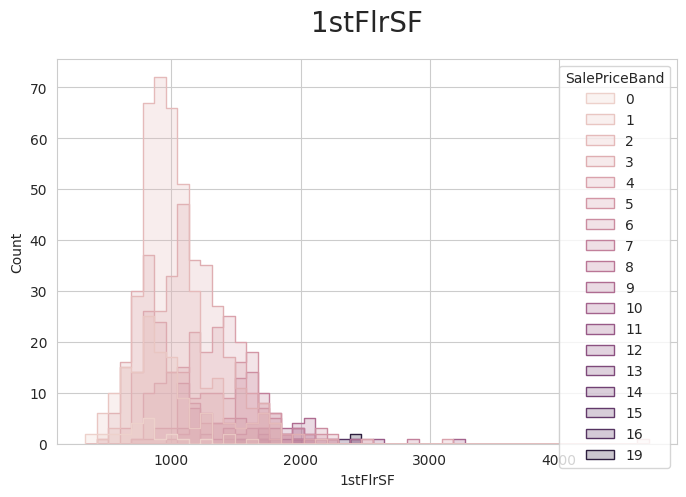

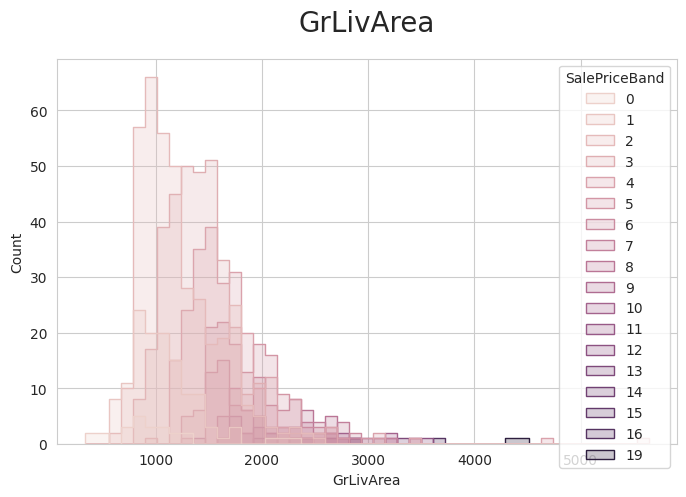

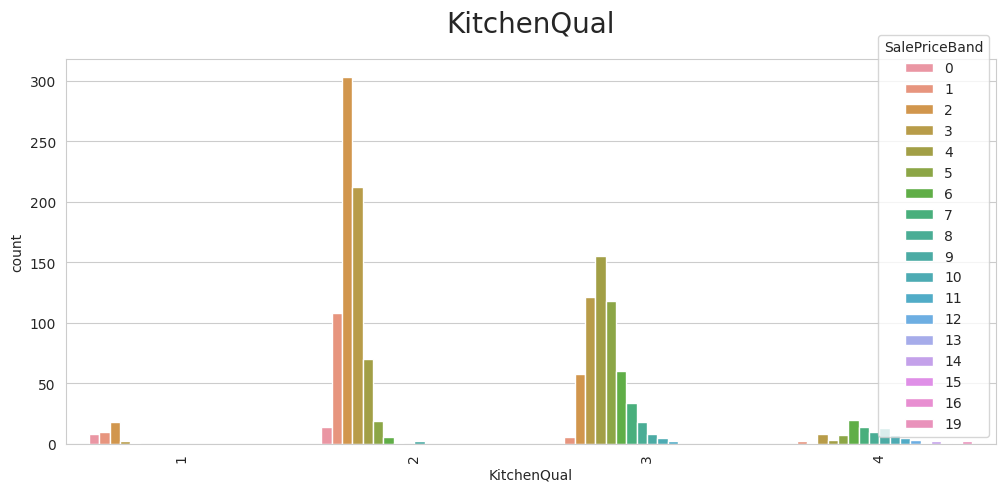

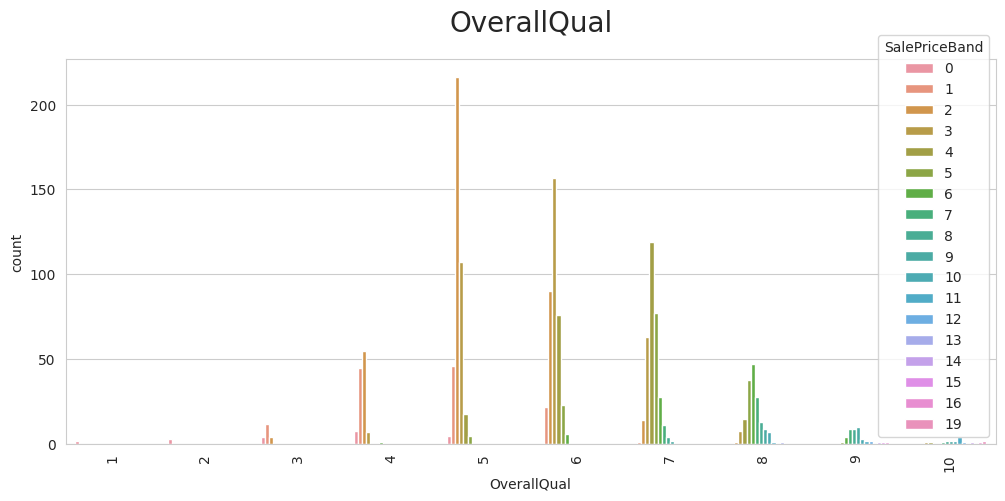

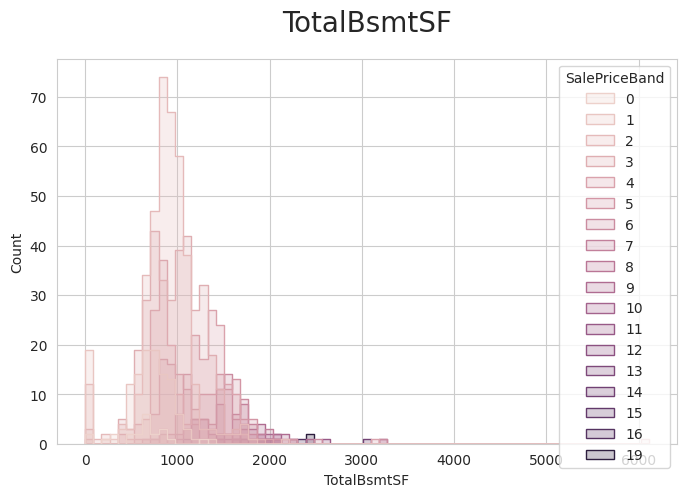

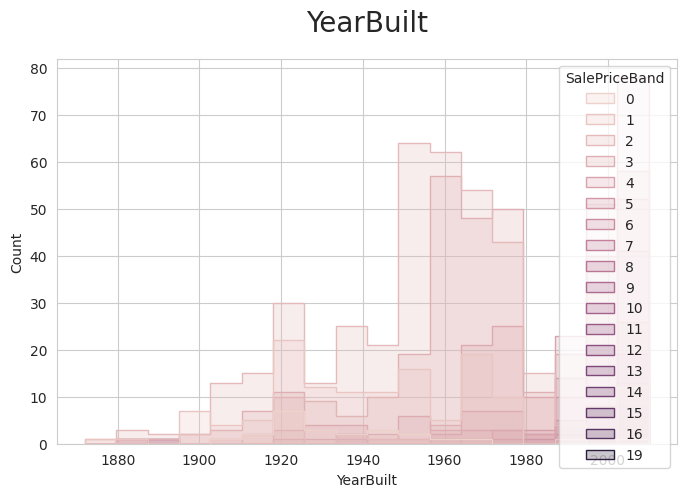

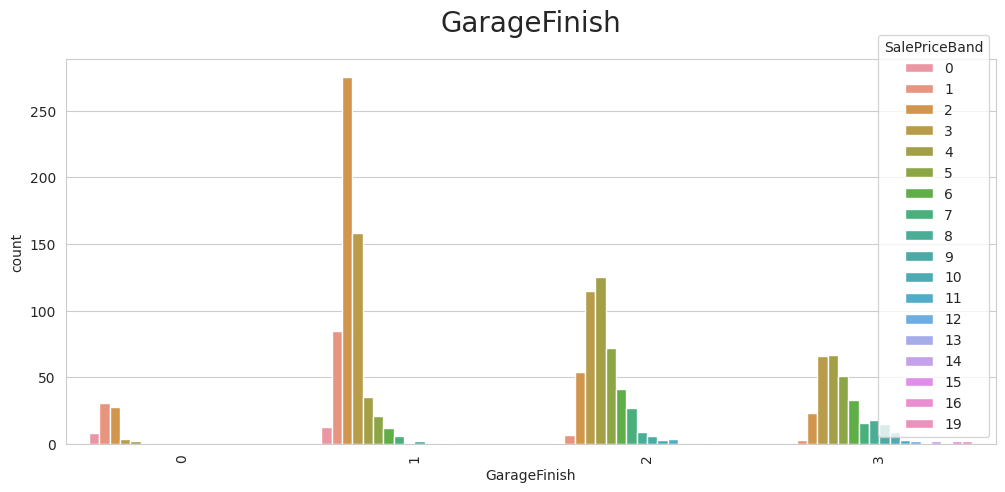

In [19]:
# Examining variable distribution for highly correlated variables by SalePriceBand

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

def plot_categorical(df_houseprices, col, target_var):

  plt.figure(figsize=(12, 5))
  sns.countplot(data=df_houseprices, x=col, hue=target_var)
  plt.xticks(rotation=90)
  plt.title(f"{col}", fontsize=20, y=1.05)
  plt.show()


def plot_numerical(df_houseprices, col, target_var):
  plt.figure(figsize=(8, 5))
  sns.histplot(data=df_houseprices, x=col, hue=target_var, element="step")
  plt.title(f"{col}", fontsize=20, y=1.05)
  plt.show()


target_var = 'SalePriceBand'
for col in vars_to_study:
  if df_houseprices_eda[col].dtype == 'object':
    plot_categorical(df_houseprices_eda, col, target_var)
    print("\n\n")
  else:
    plot_numerical(df_houseprices_eda, col, target_var)
    print("\n\n")



#### *Observations*

*

# Correlation and Heatmap for All variables

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%   75%    max
ppscore  462.0  0.055  0.122  0.0  0.0  0.0  0.06  0.992


* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



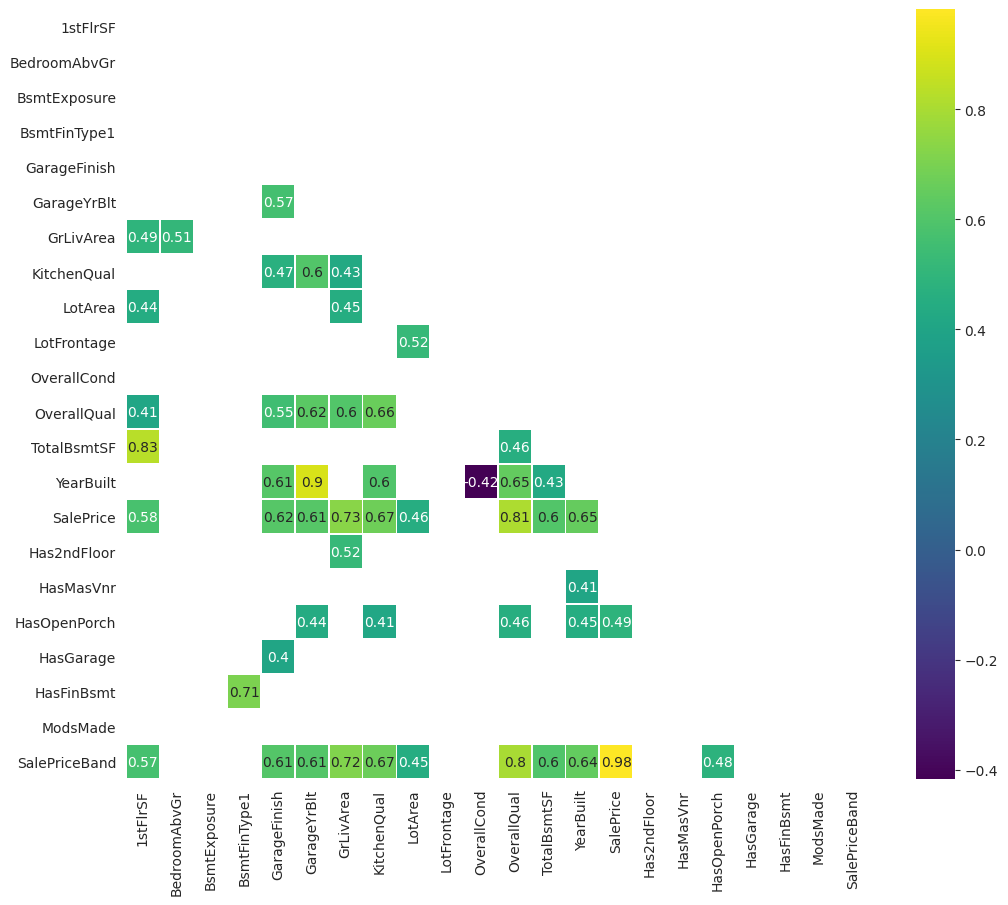



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



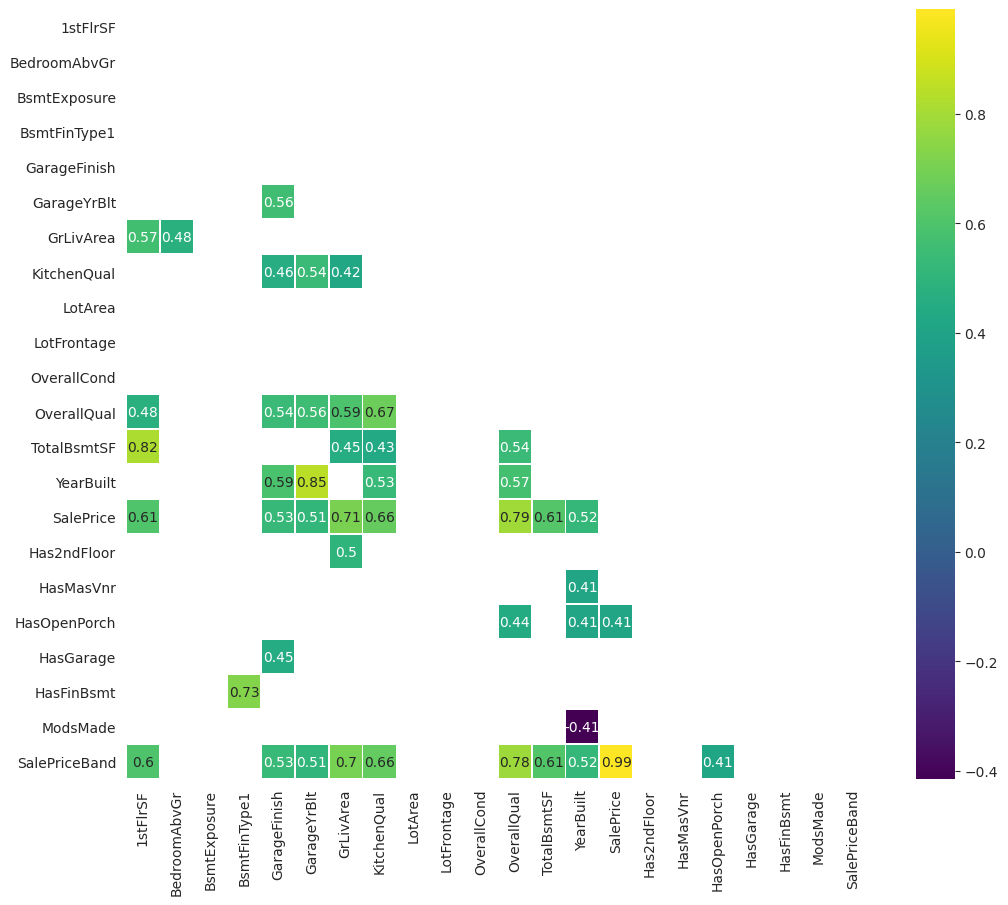



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



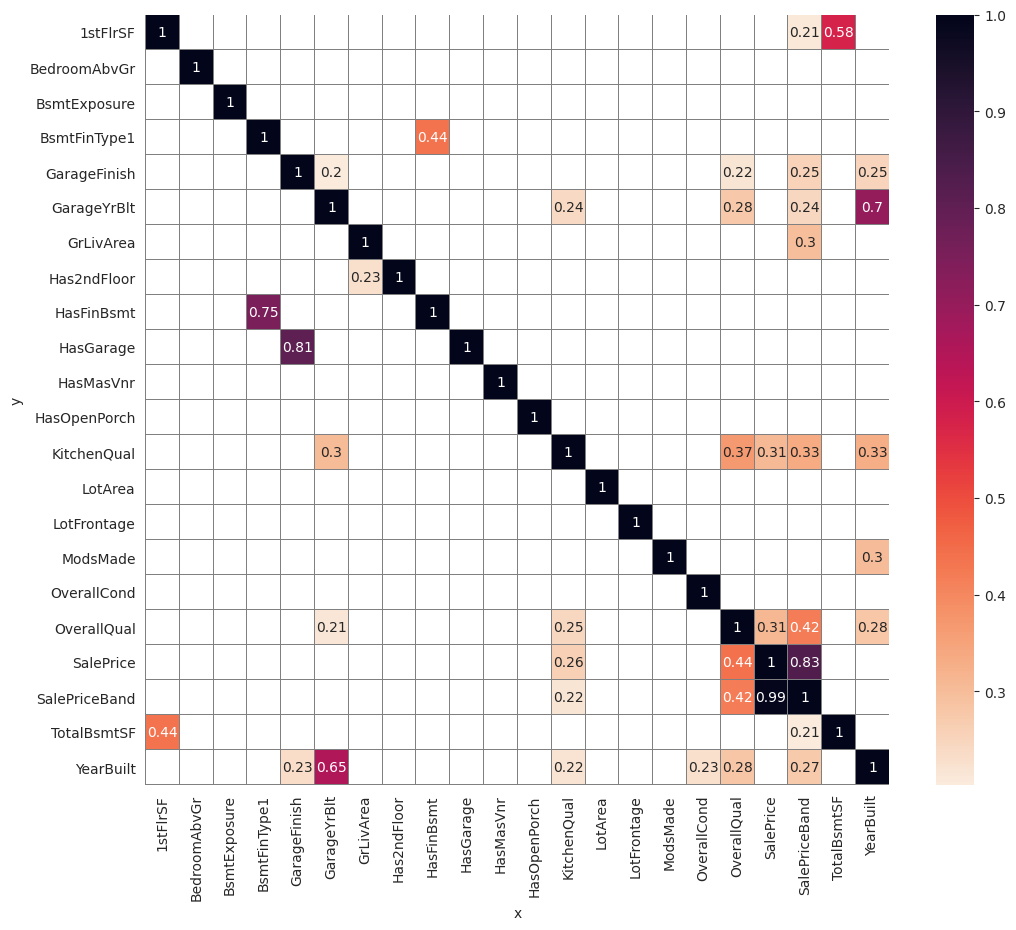

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df_houseprices, threshold, figsize=(20, 12), font_annot=8):
  if len(df_houseprices.columns) > 1:
    mask = np.zeros_like(df_houseprices, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df_houseprices) < threshold] = True

    fig, axes = plt.subplots(figsize=figsize)
    sns.heatmap(df_houseprices, annot=True, xticklabels=True, yticklabels=True,
          mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
          linewidth=0.5
          )
    axes.set_yticklabels(df_houseprices.columns, rotation=0)
    plt.ylim(len(df_houseprices.columns), 0)
    plt.show()


def heatmap_pps(df_houseprices, threshold, figsize=(20, 12), font_annot=8):
  if len(df_houseprices.columns) > 1:
    mask = np.zeros_like(df_houseprices, dtype=np.bool)
    mask[abs(df_houseprices) < threshold] = True
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(df_houseprices, annot=True, xticklabels=True, yticklabels=True,
             mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
             linewidth=0.05, linecolor='grey')
    plt.ylim(len(df_houseprices.columns), 0)
    plt.show()


def CalculateCorrAndPPS(df_houseprices):
  df_corr_spearman = df_houseprices.corr(method="spearman")
  df_corr_pearson = df_houseprices.corr(method="pearson")

  pps_matrix_raw = pps.matrix(df_houseprices)
  pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

  pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
  print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
  print(pps_score_stats.round(3))

  return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
           figsize=(20, 12), font_annot=8):

  print("\n")
  print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
  print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

  print("\n")
  print("*** Heatmap: Spearman Correlation ***")
  print("It evaluates monotonic relationship \n")
  heatmap_corr(df_houseprices=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Pearson Correlation ***")
  print("It evaluates the linear relationship between two continuous variables \n")
  heatmap_corr(df_houseprices=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Power Predictive Score (PPS) ***")
  print(f"PPS detects linear or non-linear relationships between two columns.\n"
     f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
  heatmap_pps(df_houseprices=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df_houseprices)

DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
         df_corr_spearman = df_corr_spearman, 
         pps_matrix = pps_matrix,
         CorrThreshold = 0.4, PPS_Threshold =0.2,
         figsize=(12,10), font_annot=10)


---

# Save as new Clean dataset

In [21]:
# Save as file in collections folder

import os
try:
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/datasets/cleaned'


In [22]:
df_houseprices.to_csv("outputs/datasets/cleaned/HousePricesClean.csv", index=False)

# Conclusions and Next Steps

---